<a href="https://colab.research.google.com/github/DavidSenseman/BIO1173/blob/main/Class_02_4_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- BIO1173_CLASS_02_4 -->

---------------------------
**COPYRIGHT NOTICE:** This Jupyterlab Notebook is a Derivative work of [Jeff Heaton](https://github.com/jeffheaton) licensed under the Apache License, Version 2.0 (the "License"); You may not use this file except in compliance with the License. You may obtain a copy of the License at

> [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

------------------------

# **BIO 1173: Intro Computational Biology**

##### **Module 2: Neural Networks with PyTorch**

* Instructor: [David Senseman](mailto:David.Senseman@utsa.edu), [Department of Biology, Health and the Environment](https://sciences.utsa.edu/bhe/), [UTSA](https://www.utsa.edu/)

### Module 2 Material

* Part 2.1: Introduction to Neural Networks with PyTorch
* Part 2.2: Encoding Feature Vectors
* Part 2.3: Controlling Overfitting
* **Part 2.4: Saving and Loading a PyTorch Neural Network**

## Google CoLab Instructions

You MUST run the following code cell to get credit for this class lesson. By running this code cell, you will map your GDrive to /content/drive and print out your Google GMAIL address. Your Instructor will use your GMAIL address to verify the author of this class lesson.

In [1]:
# You must run this cell first
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    from google.colab import auth
    auth.authenticate_user()
    Colab = True
    print("Note: Using Google CoLab")
    import requests
    gcloud_token = !gcloud auth print-access-token
    gcloud_tokeninfo = requests.get('https://www.googleapis.com/oauth2/v3/tokeninfo?access_token=' + gcloud_token[0]).json()
    print(gcloud_tokeninfo['email'])
except:
    print("**WARNING**: Your GMAIL address was **not** printed in the output below.")
    print("**WARNING**: You will NOT receive credit for this lesson.")
    Colab = False

Mounted at /content/drive
Note: Using Google CoLab
david.senseman@gmail.com


You should see the following output except your GMAIL address should appear on the last line.
```text
Mounted at /content/drive
Note: Using Google CoLab
studentbio1173@gmail.com
```

If your GMAIL address does not appear your lesson will **not** be graded.

### Create Custom Functions

Run the cell below to create one (or more) function(s) needed for this lesson.

In [2]:
# Simple function to print out elasped time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# **Saving and Loading a PyTorch Neural Network**

Complex neural networks will take a _long_ time to train.  It is helpful to be able to save a trained neural network so that you can reload it and using it again--a reloaded neural network will **not** require retraining.  

PyTorch provides the following formats for saving neural networks:

* **State Dict** - Stores the model's state dictionary (weights and biases) in a format that can be easily loaded back into the same model architecture.
* **Full Model** - Stores the complete neural network including both the model architecture and weights in a single file.

Usually, you will want to save using the state dict approach as it's more flexible and memory efficient. The state dict only saves the parameters (weights and biases) while keeping the model class definition separate, allowing you to load the weights into different model architectures if needed.

A primary goal of this lesson is to convince you that a PyTorch model that you "regenerate" from a file that was saved to your Google Drive, is exactly the same (i.e. same accuracy) as the original PyTorch model you created and trained.

### Example 1A: Build and Train a Classification Neural Network

The code in `Example 1A` builds, compiles and trains a neural network called `or_model` that can classify the Quality of an orange based on its physical and chemical characteristics.

The code in the cell below reads the Orange Quality dataset from the course HTTP server and creates a DataFrame called `or_df` (i.e. "orange" DataFrame) using this code snippet:

```Python
or_df = pd.read_csv(
"https://biologicslab.co/BIO1173/data/orange_quality.csv",
    na_values=['NA', '?'])
```

In order to create a feature vector, the 3 non-numeric columns in the dataset: `Color`, `Variety` and `Blemished` must be pre-processed as follows:
1. **Mapping strings to integers:** This is used to take care of the column `Color` which contains several string values. Here is the code snippet that does the mapping:

```Python
# Map str to int
or_mapping = {'Orange':0,'Deep Orange':1,'Light Orange':2,'Orange-Red':3,'Yellow-Orange':4} or_df['Color'] = or_df['Color'].map(or_mapping)
```

2. **Normalization:** The following code chunk identifies which columns in `or_df` are numeric and then applies Z-normalization to the numeric values.
    
```Python
# Standardise all numeric column with z‑score
or_numeric_cols = or_df.select_dtypes(include=['int64', 'float64']).columns or_df[or_numeric_cols] = or_df[or_numeric_cols].apply(zscore) numeric_cols = or_df.select_dtypes(include=['int64', 'float64']).columns
```

3. **Exclude Columns:** To take care the string values in the columns `Variety` and `Blemished`, we will simply exclude them from the list of columns to be used for creating the X feature vector `or_X`:

```Python
# Generate X-values
or_X = or_df[['Size (cm)', 'Weight (g)', 'Brix (Sweetness)', 'pH (Acidity)','Softness (1-5)', 'HarvestTime (days)', 'Ripeness (1-5)','Color']].values or_X = np.asarray(or_X).astype('float32')
```

Since we are building a classification neural network, we will need to one-hot encode the column `Quality (1-5)` which contains the `Y-values` using this code snippet:

```Python
# Generate y-values (one-hot encoding)
or_dummies = pd.get_dummies(or_df['Quality (1-5)'], dtype=int)
or_Y = or_dummies.values
or_Y = np.asarray(or_Y).astype('float32')
```

It should be noted that this column is already numeric, so we are **not** using one-hot encoding to replace string values with integer. Rather, one-hot encoding the `Y-values` is necessary to give them the **correct format** for the neural network.


In [9]:
# @title Example 1A: Build and Train a Classification Neural Network

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import time
import numpy as np
from scipy.stats import zscore
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
or_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/orange_quality.csv",
    na_values=['NA', '?'])

# ------------------------------------------------------------
#  3️⃣ Preprocessing
# ------------------------------------------------------------

# Map str to int
or_mapping = {'Orange':0,'Deep Orange':1,
           'Light Orange':2,'Orange-Red':3,
           'Yellow-Orange':4}
or_df['Color'] = or_df['Color'].map(or_mapping)

# Standardise all numeric column with z‑score
or_numeric_cols = or_df.select_dtypes(include=['int64', 'float64']).columns
or_df[or_numeric_cols] = or_df[or_numeric_cols].apply(zscore)


# Generate X-values
or_X = or_df[['Size (cm)', 'Weight (g)', 'Brix (Sweetness)', 'pH (Acidity)',
       'Softness (1-5)', 'HarvestTime (days)', 'Ripeness (1-5)',
        'Color']].values
or_X = np.asarray(or_X).astype('float32')

# Generate Y-values
or_dummies = pd.get_dummies(or_df['Quality (1-5)'], dtype=int) # Classification
or_Y = or_dummies.values
or_Y = np.asarray(or_Y).astype('float32')

# ------------------------------------------------------------
# 4️⃣  Prepare data for PyTorch
# ------------------------------------------------------------

# Convert to PyTorch tensors
or_X_tensor = torch.FloatTensor(or_X)
or_y_tensor = torch.LongTensor(np.argmax(or_Y, axis=1))  # Convert one-hot to class indices

# Split into train and validation sets
or_X_train, or_X_val, or_y_train, or_y_val = train_test_split(
    or_X_tensor, or_y_tensor, test_size=0.2, random_state=42
)

# Create data loaders
or_train_dataset = TensorDataset(or_X_train, or_y_train)
or_val_dataset = TensorDataset(or_X_val, or_y_val)
or_train_loader = DataLoader(or_train_dataset, batch_size=32, shuffle=True)
or_val_loader = DataLoader(or_val_dataset, batch_size=32, shuffle=False)

# ------------------------------------------------------------
# 5️⃣   Define model
# ------------------------------------------------------------

class OrangeQualityModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OrangeQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)  # No softmax here - it's included in CrossEntropyLoss
        return x

# Create model instance
or_input_dim = or_X_train.shape[1]
or_num_classes = or_Y.shape[1]
or_model = OrangeQualityModel(or_input_dim, or_num_classes)

# ------------------------------------------------------------
# 6️⃣  Define optimizer and loss function
# ------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(or_model.parameters(), lr=0.001)

# ------------------------------------------------------------
# 7️⃣  Training loop with early stopping and history tracking
# ------------------------------------------------------------

# Initialize history tracking lists
or_train_losses = []
or_val_losses = []
or_train_accuracies = []
or_val_accuracies = []

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0

print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

for epoch in range(EPOCHS):
    # Training phase
    or_model.train()
    or_train_loss = 0.0
    or_train_correct = 0
    or_train_total = 0

    for inputs, labels in or_train_loader:
        optimizer.zero_grad()
        outputs = or_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        or_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        or_train_total += labels.size(0)
        or_train_correct += (predicted == labels).sum().item()

    # Validation phase
    or_model.eval()
    or_val_loss = 0.0
    or_val_correct = 0
    or_val_total = 0

    with torch.no_grad():
        for inputs, labels in or_val_loader:
            outputs = or_model(inputs)
            loss = criterion(outputs, labels)

            or_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            or_val_total += labels.size(0)
            or_val_correct += (predicted == labels).sum().item()

    # Calculate accuracies
    or_train_acc = 100. * or_train_correct / or_train_total
    or_val_acc = 100. * or_val_correct / or_val_total

    # Store history for plotting
    or_train_losses.append(or_train_loss/len(or_train_loader))
    or_val_losses.append(or_val_loss/len(or_val_loader))
    or_train_accuracies.append(or_train_acc)
    or_val_accuracies.append(or_val_acc)

    if VERBOSE > 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}]')
        print(f'Train Loss: {or_train_loss/len(or_train_loader):.4f}, '
              f'Train Acc: {or_train_acc:.2f}%')
        print(f'Val Loss: {or_val_loss/len(or_val_loader):.4f}, '
              f'Val Acc: {or_val_acc:.2f}%')
        print('-' * 50)


    # Early stopping logic
    if or_val_acc > best_val_acc:
        best_val_acc = or_val_acc
        patience_counter = 0
        # Save best model
        torch.save(or_model.state_dict(), "or_best_classification_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ---------------------------------------------------------------------------
# 8️⃣  Inspect training - Now with proper history tracking
# ---------------------------------------------------------------------------

print(f"\nTraining finished.")
print(f"Best validation accuracy: {best_val_acc:.4f}")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# Show the best validation accuracy and loss (same as original)
best_val_acc_history = max(or_val_accuracies) if or_val_accuracies else 0.0
best_val_loss_history = min(or_val_losses) if or_val_losses else float('inf')

print(f"Best validation accuracy: {best_val_acc_history:.4f}")
print(f"Best validation loss: {best_val_loss_history:.4f}")

# Load the best model for final evaluation if needed
or_model.load_state_dict(torch.load("or_best_classification_model.pth"))

------Training Starting for 100 epochs --------------
Epoch [1/100]
Train Loss: 2.0795, Train Acc: 18.23%
Val Loss: 2.0129, Val Acc: 32.65%
--------------------------------------------------
Epoch [2/100]
Train Loss: 1.9579, Train Acc: 27.08%
Val Loss: 1.9166, Val Acc: 42.86%
--------------------------------------------------
Epoch [3/100]
Train Loss: 1.7508, Train Acc: 39.58%
Val Loss: 1.8088, Val Acc: 40.82%
--------------------------------------------------
Epoch [4/100]
Train Loss: 1.6447, Train Acc: 47.92%
Val Loss: 1.7211, Val Acc: 42.86%
--------------------------------------------------
Epoch [5/100]
Train Loss: 1.5905, Train Acc: 47.40%
Val Loss: 1.6494, Val Acc: 42.86%
--------------------------------------------------
Epoch [6/100]
Train Loss: 1.5185, Train Acc: 47.40%
Val Loss: 1.6059, Val Acc: 46.94%
--------------------------------------------------
Epoch [7/100]
Train Loss: 1.5025, Train Acc: 48.96%
Val Loss: 1.5701, Val Acc: 44.90%
--------------------------------------

<All keys matched successfully>

If the code is correct you should see something _similar_ to the following output:
```text
------Training Starting for 100 epochs --------------
Epoch [1/100]
Train Loss: 2.1255, Train Acc: 14.58%
Val Loss: 1.9728, Val Acc: 38.78%
--------------------------------------------------
Epoch [2/100]
Train Loss: 1.9516, Train Acc: 27.60%
Val Loss: 1.8733, Val Acc: 40.82%
--------------------------------------------------
Epoch [3/100]
Train Loss: 1.8267, Train Acc: 33.33%
Val Loss: 1.7741, Val Acc: 36.73%
--------------------------------------------------
Epoch [4/100]
Train Loss: 1.7224, Train Acc: 42.19%
Val Loss: 1.6806, Val Acc: 40.82%
--------------------------------------------------
Epoch [5/100]
Train Loss: 1.6149, Train Acc: 44.27%
Val Loss: 1.6088, Val Acc: 40.82%
--------------------------------------------------
Epoch [6/100]
Train Loss: 1.5469, Train Acc: 48.44%
Val Loss: 1.5587, Val Acc: 40.82%
--------------------------------------------------
Epoch [7/100]
Train Loss: 1.4805, Train Acc: 52.08%
Val Loss: 1.5248, Val Acc: 40.82%
--------------------------------------------------
Epoch [8/100]
Train Loss: 1.4443, Train Acc: 47.92%
Val Loss: 1.5042, Val Acc: 40.82%
--------------------------------------------------
Epoch [9/100]
Train Loss: 1.4370, Train Acc: 53.12%
Val Loss: 1.4864, Val Acc: 44.90%
--------------------------------------------------
Epoch [10/100]
Train Loss: 1.4064, Train Acc: 45.83%
Val Loss: 1.4740, Val Acc: 44.90%
--------------------------------------------------
Epoch [11/100]
Train Loss: 1.4126, Train Acc: 56.77%
Val Loss: 1.4640, Val Acc: 44.90%
--------------------------------------------------
Epoch [12/100]
Train Loss: 1.4329, Train Acc: 50.52%
Val Loss: 1.4566, Val Acc: 42.86%
--------------------------------------------------
Epoch [13/100]
Train Loss: 1.3214, Train Acc: 60.42%
Val Loss: 1.4451, Val Acc: 42.86%
--------------------------------------------------
Epoch [14/100]
Train Loss: 1.3171, Train Acc: 57.29%
Val Loss: 1.4330, Val Acc: 42.86%
--------------------------------------------------
Epoch [15/100]
Train Loss: 1.3055, Train Acc: 55.73%
Val Loss: 1.4267, Val Acc: 44.90%
--------------------------------------------------
Epoch [16/100]
Train Loss: 1.2657, Train Acc: 57.81%
Val Loss: 1.4167, Val Acc: 44.90%
--------------------------------------------------
Epoch [17/100]
Train Loss: 1.2969, Train Acc: 54.17%
Val Loss: 1.4063, Val Acc: 44.90%
--------------------------------------------------
Epoch [18/100]
Train Loss: 1.2549, Train Acc: 62.50%
Val Loss: 1.4012, Val Acc: 44.90%
--------------------------------------------------
Epoch [19/100]
Train Loss: 1.2340, Train Acc: 53.65%
Val Loss: 1.3899, Val Acc: 42.86%
--------------------------------------------------
Early stopping at epoch 19

Training finished.
Best validation accuracy: 44.8980
Elapsed time: 0:00:00.36
Best validation accuracy: 44.8980
Best validation loss: 1.3899
<All keys matched successfully>
```

The `or_model` neural network trained very quickly (< 1 min) but the best validation accuracy (`val accuracy`) is only about 40-45%. It should also be noted that in this particular run, `Early Stopping` terminated training before the 20th epoch.

### Example 1B: Plot Training History

The code in the cell below generates two side-by-side plots, an **Accuracy Curve** and a **Loss Curve**. These curves provide a visual way to follow what happened during training of `or_model`.

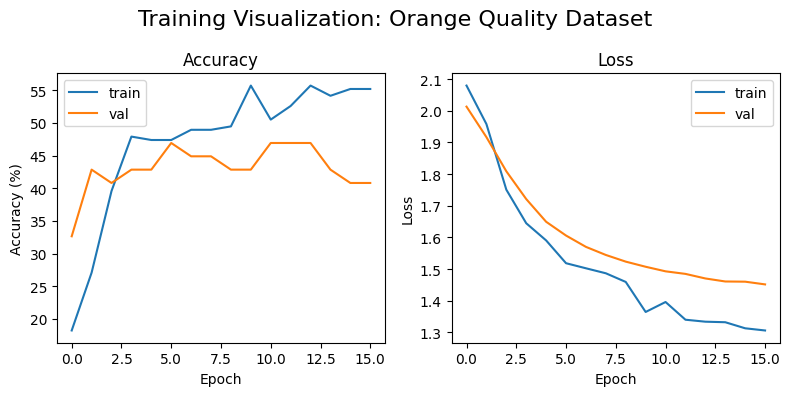

In [10]:
# @title Example 1B: Plot Training History

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Main title above both subplots
plt.suptitle('Training Visualization: Orange Quality Dataset',
             fontsize=16, fontweight='medium')

plt.subplot(1,2,1)
plt.plot(or_train_accuracies, label='train')
plt.plot(or_val_accuracies, label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(or_train_losses, label='train')
plt.plot(or_val_losses, label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output:

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_4_image01A.png)


### **Exercise 1A: Build and Train a Classification Neural Network**

In the cell below build and train a new classification neural network called `ap_model`.

Start by reading the dataset and creating a DataFrame called ap_df ("apple" DataFrame) using this code chunk:

```Python

ap_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/apple_quality.csv",
    na_values=['NA', '?'])

```

The goal of your neural network model ap_model will be to classify the apples in the Apple Quality dataset using the values in the following columns: 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Acidity' and 'Ripeness'. Since all of these columns are numeric, there is no need pre-process any of these columns. Moreover, the numerical values all have a similar magnitude so you don't need to standardize any column to their z-scores. Nor do you need to split the data into Training/Validation sets or suffle the data. When you generate your X-values, you should called them ap_X.

Since you are building a classification neural network, you will need to One-Hot Encode the column containing the Y-values, Quality. This column is non-numeric, so by One-Hot Encoding it, you will accomplish two things: (1) replace string values with integers and (2) give the Y-values the correct format for the neural network. When you generate your Y-values, you should called them ap_Y.

Again, because you want your ap_model to act as a classifier, use the softmax activation function in the output layer. You should also compile your model using categorical_crossentropy as the loss function.

Finally, train (fit) your model on your X-values (ap_X) and your Y-values (ap_Y) for 100 epochs.

### **Exercise 1: Build and Train a Classification Neural Network**

In the cell below build and train a new classification neural network called `ap_model`.

Start by `copy-and-paste` Example 1 into the cell below.

Read the **`Apple Quality dataset`** and creat a DataFrame called `ap_df` ("apple" DataFrame) using this code chunk:

```Python
ap_df = pd.read_csv(
"https://biologicslab.co/BIO1173/data/apple_quality.csv",
na_values=['NA', '?'])
```

The goal of your training your neural network model `ap_model` will be to learn how to predict the classification apples using the values in the following columns: 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Acidity' and 'Ripeness'. Since all of these columns are numeric you should standardize their values by converting them to their z-scores. You can simply re-use the code in `Example 1` making sure to change the prefix `or_` to `ap_`.

Again, since all of these columns are numeric, there is no need map any strings to integers as was done in `Example 1`. The easiest and _safest_ way to accomplish this is to simply comment-out the unecessary code in `Example 1` as follows:


```Python
# Map str to int
#mapping = {'Orange':0,'Deep Orange':1,
#           'Light Orange':2,'Orange-Red':3,
#           'Yellow-Orange':4}
#or_df['Color'] = or_df['Color'].map(mapping)
```

Commenting-out code instead of simply deleting it has the distinct advantage that if you make a mistake, is relatively easy to correct it by simply adding (or removing) the **`#`** before the line.


To generate your X feature vector change this code chunk
```Python
# Generate X-values
or_X = or_df[['Size (cm)', 'Weight (g)', 'Brix (Sweetness)', 'pH (Acidity)',
'Softness (1-5)', 'HarvestTime (days)', 'Ripeness (1-5)', 'Color']].values or_X = np.asarray(or_X).astype('float32')
```
to read as
```Python
# Generate X‑values
ap_X = ap_df[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Acidity', 'Ripeness']].values ap_X = np.asarray(ap_X).astype('float32')
```

This will make sure on the correct columns are used to generate your `X` feature vector.

Since you are building a classification neural network, you will need to one-Hot encode the column called `Quality` containing your `Y-values`. You can simple re-use the code in `Example 1`, making sure to use the correct name for the target column (i.e `Quality`).

Finally, train (fit) your model on your X-values (`ap_X`) and your Y-values (`ap_Y`) for 100 epochs with verbose set to `0`.  

In [11]:
# @title Exercise 1: Build and Train a Classification Neural Networ

# ------------------------------------------------------------
# 0️⃣  Imports
# ------------------------------------------------------------
import pandas as pd
import time
import numpy as np
from scipy.stats import zscore
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣  Parameters
# ------------------------------------------------------------
EPOCHS        = 100
PATIENCE      = 10
VERBOSE       = 2

# ------------------------------------------------------------
# 2️⃣  Load data
# ------------------------------------------------------------
ap_df = pd.read_csv(
    "https://biologicslab.co/BIO1173/data/apple_quality.csv",
    na_values=['NA', '?'])

# ------------------------------------------------------------
# 5️⃣  Preprocessing
# ------------------------------------------------------------

# Map str to int
#or_mapping = {'Orange':0,'Deep Orange':1,
#           'Light Orange':2,'Orange-Red':3,
#           'Yellow-Orange':4}
#or_df['Color'] = or_df['Color'].map(or_mapping)

# Standardise all numeric column with z‑score
ap_numeric_cols = ap_df.select_dtypes(include=['int64', 'float64']).columns
ap_df[ap_numeric_cols] = ap_df[ap_numeric_cols].apply(zscore)

# Generate X‑values
ap_X = ap_df[['Size', 'Weight', 'Sweetness', 'Crunchiness',
              'Juiciness', 'Acidity', 'Ripeness']].values
ap_X = np.asarray(ap_X).astype('float32')

# Generate Y-values
ap_dummies = pd.get_dummies(ap_df['Quality'], dtype=int) # Classification
ap_Y = ap_dummies.values
ap_Y = np.asarray(ap_Y).astype('float32')

# ------------------------------------------------------------
# 6️⃣  Prepare data for PyTorch
# ------------------------------------------------------------

# Convert to PyTorch tensors
ap_X_tensor = torch.FloatTensor(ap_X)
ap_y_tensor = torch.LongTensor(np.argmax(ap_Y, axis=1))  # Convert one-hot to class indices

# Split into train and validation sets
ap_X_train, ap_X_val, ap_y_train, ap_y_val = train_test_split(
    ap_X_tensor, ap_y_tensor, test_size=0.2, random_state=42
)

# Create data loaders
ap_train_dataset = TensorDataset(ap_X_train, ap_y_train)
ap_val_dataset = TensorDataset(ap_X_val, ap_y_val)
ap_train_loader = DataLoader(ap_train_dataset, batch_size=32, shuffle=True)
ap_val_loader = DataLoader(ap_val_dataset, batch_size=32, shuffle=False)

# ------------------------------------------------------------
# 7️⃣  Define model
# ------------------------------------------------------------

class AppleQualityModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(AppleQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)  # No softmax here - it's included in CrossEntropyLoss
        return x

# Create model instance
ap_input_dim = ap_X_train.shape[1]
ap_num_classes = ap_Y.shape[1]
ap_model = AppleQualityModel(ap_input_dim, ap_num_classes)

# ------------------------------------------------------------
# 8️⃣  Define optimizer and loss function
# ------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ap_model.parameters(), lr=0.001)

# ------------------------------------------------------------
# 9️⃣  Training loop with early stopping and history tracking
# ------------------------------------------------------------

# Initialize history tracking lists
ap_train_losses = []
ap_val_losses = []
ap_train_accuracies = []
ap_val_accuracies = []

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0

print(f"------Training Starting for {EPOCHS} epochs --------------")
start_time = time.time()

for epoch in range(EPOCHS):
    # Training phase
    ap_model.train()
    ap_train_loss = 0.0
    ap_train_correct = 0
    ap_train_total = 0

    for inputs, labels in ap_train_loader:
        optimizer.zero_grad()
        outputs = ap_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        ap_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        ap_train_total += labels.size(0)
        ap_train_correct += (predicted == labels).sum().item()

    # Validation phase
    ap_model.eval()
    ap_val_loss = 0.0
    ap_val_correct = 0
    ap_val_total = 0

    with torch.no_grad():
        for inputs, labels in ap_val_loader:
            outputs = ap_model(inputs)
            loss = criterion(outputs, labels)

            ap_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            ap_val_total += labels.size(0)
            ap_val_correct += (predicted == labels).sum().item()

    # Calculate accuracies
    ap_train_acc = 100. * ap_train_correct / ap_train_total
    ap_val_acc = 100. * ap_val_correct / ap_val_total

    # Store history for plotting
    ap_train_losses.append(ap_train_loss/len(ap_train_loader))
    ap_val_losses.append(ap_val_loss/len(ap_val_loader))
    ap_train_accuracies.append(ap_train_acc)
    ap_val_accuracies.append(ap_val_acc)

    if VERBOSE > 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}]')
        print(f'Train Loss: {ap_train_loss/len(ap_train_loader):.4f}, '
              f'Train Acc: {ap_train_acc:.2f}%')
        print(f'Val Loss: {ap_val_loss/len(ap_val_loader):.4f}, '
              f'Val Acc: {ap_val_acc:.2f}%')
        print('-' * 50)


    # Early stopping logic
    if ap_val_acc > best_val_acc:
        best_val_acc = ap_val_acc
        patience_counter = 0
        # Save best model
        torch.save(ap_model.state_dict(), "ap_best_classification_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ---------------------------------------------------------------------------
# 10️⃣ Inspect training - Now with proper history tracking
# ---------------------------------------------------------------------------

print(f"\nTraining finished.")
print(f"Best validation accuracy: {best_val_acc:.4f}")

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

# Show the best validation accuracy and loss (same as original)
best_val_acc_history = max(ap_val_accuracies) if ap_val_accuracies else 0.0
best_val_loss_history = min(ap_val_losses) if ap_val_losses else float('inf')

print(f"Best validation accuracy: {best_val_acc_history:.4f}")
print(f"Best validation loss: {best_val_loss_history:.4f}")

# Load the best model for final evaluation if needed
ap_model.load_state_dict(torch.load("ap_best_classification_model.pth"))


------Training Starting for 100 epochs --------------
Epoch [1/100]
Train Loss: 0.4753, Train Acc: 76.31%
Val Loss: 0.3368, Val Acc: 87.38%
--------------------------------------------------
Epoch [2/100]
Train Loss: 0.3888, Train Acc: 82.09%
Val Loss: 0.3093, Val Acc: 88.38%
--------------------------------------------------
Epoch [3/100]
Train Loss: 0.3701, Train Acc: 82.91%
Val Loss: 0.2996, Val Acc: 88.50%
--------------------------------------------------
Epoch [4/100]
Train Loss: 0.3612, Train Acc: 83.41%
Val Loss: 0.2907, Val Acc: 89.88%
--------------------------------------------------
Epoch [5/100]
Train Loss: 0.3456, Train Acc: 83.78%
Val Loss: 0.2848, Val Acc: 89.62%
--------------------------------------------------
Epoch [6/100]
Train Loss: 0.3369, Train Acc: 84.44%
Val Loss: 0.2790, Val Acc: 89.62%
--------------------------------------------------
Epoch [7/100]
Train Loss: 0.3339, Train Acc: 85.22%
Val Loss: 0.2765, Val Acc: 89.00%
--------------------------------------

<All keys matched successfully>

If the code is correct you should see something _similar_ to the following output:
```text
------Training Starting for 100 epochs --------------
Epoch [1/100]
Train Loss: 0.4976, Train Acc: 75.47%
Val Loss: 0.3623, Val Acc: 85.50%
--------------------------------------------------
Epoch [2/100]
Train Loss: 0.3888, Train Acc: 81.88%
Val Loss: 0.3093, Val Acc: 88.62%
--------------------------------------------------
Epoch [3/100]
Train Loss: 0.3749, Train Acc: 82.47%
Val Loss: 0.2911, Val Acc: 90.12%
--------------------------------------------------
Epoch [4/100]
Train Loss: 0.3471, Train Acc: 83.31%
Val Loss: 0.2793, Val Acc: 89.62%
--------------------------------------------------
Epoch [5/100]
Train Loss: 0.3534, Train Acc: 84.53%
Val Loss: 0.2800, Val Acc: 89.00%
--------------------------------------------------
Epoch [6/100]
Train Loss: 0.3357, Train Acc: 84.50%
Val Loss: 0.2761, Val Acc: 89.25%
--------------------------------------------------
Epoch [7/100]
Train Loss: 0.3400, Train Acc: 85.06%
Val Loss: 0.2663, Val Acc: 90.12%
--------------------------------------------------
Epoch [8/100]
Train Loss: 0.3251, Train Acc: 85.56%
Val Loss: 0.2615, Val Acc: 90.50%
--------------------------------------------------
Epoch [9/100]
Train Loss: 0.3256, Train Acc: 85.53%
Val Loss: 0.2626, Val Acc: 90.25%
--------------------------------------------------
Epoch [10/100]
Train Loss: 0.3147, Train Acc: 85.81%
Val Loss: 0.2525, Val Acc: 91.12%
--------------------------------------------------
Epoch [11/100]
Train Loss: 0.2941, Train Acc: 86.97%
Val Loss: 0.2464, Val Acc: 92.00%
--------------------------------------------------
Epoch [12/100]
Train Loss: 0.3063, Train Acc: 86.34%
Val Loss: 0.2439, Val Acc: 91.00%
--------------------------------------------------
Epoch [13/100]
Train Loss: 0.3115, Train Acc: 86.09%
Val Loss: 0.2444, Val Acc: 92.25%
--------------------------------------------------
Epoch [14/100]
Train Loss: 0.2973, Train Acc: 86.75%
Val Loss: 0.2419, Val Acc: 92.12%
--------------------------------------------------
Epoch [15/100]
Train Loss: 0.2954, Train Acc: 87.31%
Val Loss: 0.2331, Val Acc: 92.75%
--------------------------------------------------
Epoch [16/100]
Train Loss: 0.2942, Train Acc: 86.88%
Val Loss: 0.2315, Val Acc: 92.75%
--------------------------------------------------
Epoch [17/100]
Train Loss: 0.2823, Train Acc: 88.28%
Val Loss: 0.2268, Val Acc: 93.25%
--------------------------------------------------
Epoch [18/100]
Train Loss: 0.2843, Train Acc: 88.06%
Val Loss: 0.2193, Val Acc: 93.00%
--------------------------------------------------
Epoch [19/100]
Train Loss: 0.2696, Train Acc: 88.59%
Val Loss: 0.2216, Val Acc: 93.25%
--------------------------------------------------
Epoch [20/100]
Train Loss: 0.2755, Train Acc: 88.34%
Val Loss: 0.2146, Val Acc: 93.12%
--------------------------------------------------
Epoch [21/100]
Train Loss: 0.2658, Train Acc: 88.50%
Val Loss: 0.2118, Val Acc: 94.00%
--------------------------------------------------
Epoch [22/100]
Train Loss: 0.2671, Train Acc: 88.72%
Val Loss: 0.2122, Val Acc: 93.25%
--------------------------------------------------
Epoch [23/100]
Train Loss: 0.2738, Train Acc: 87.94%
Val Loss: 0.2113, Val Acc: 93.50%
--------------------------------------------------
Epoch [24/100]
Train Loss: 0.2749, Train Acc: 88.38%
Val Loss: 0.2046, Val Acc: 93.38%
--------------------------------------------------
Epoch [25/100]
Train Loss: 0.2595, Train Acc: 89.22%
Val Loss: 0.2019, Val Acc: 93.38%
--------------------------------------------------
Epoch [26/100]
Train Loss: 0.2596, Train Acc: 89.00%
Val Loss: 0.1988, Val Acc: 93.88%
--------------------------------------------------
Epoch [27/100]
Train Loss: 0.2731, Train Acc: 88.53%
Val Loss: 0.1997, Val Acc: 93.88%
--------------------------------------------------
Epoch [28/100]
Train Loss: 0.2723, Train Acc: 88.31%
Val Loss: 0.2030, Val Acc: 92.38%
--------------------------------------------------
Epoch [29/100]
Train Loss: 0.2572, Train Acc: 88.84%
Val Loss: 0.1995, Val Acc: 93.75%
--------------------------------------------------
Epoch [30/100]
Train Loss: 0.2538, Train Acc: 89.41%
Val Loss: 0.1945, Val Acc: 93.38%
--------------------------------------------------
Epoch [31/100]
Train Loss: 0.2596, Train Acc: 89.25%
Val Loss: 0.1955, Val Acc: 93.12%
--------------------------------------------------
Early stopping at epoch 31

Training finished.
Best validation accuracy: 94.0000
Elapsed time: 0:00:09.60
Best validation accuracy: 94.0000
Best validation loss: 0.1945
<All keys matched successfully>
```

```text
Early stopping at epoch 19

Training finished.
Best validation accuracy: 44.8980
Elapsed time: 0:00:00.36
Best validation accuracy: 44.8980
Best validation loss: 1.3899
```
Your `ap_model` neural network appears to have done a much better job with a best validation accuracy (`val accuracy`) over 90%. It should also be noted that in this particular run, `Early Stopping` terminated training at the 32rd epoch.

### **Exercise 1B: Visualize Training**

In the cell below write the code to generate two side-by-side plots, an **Accuracy Curve** and a **Loss Curve** for your `ap_model`.

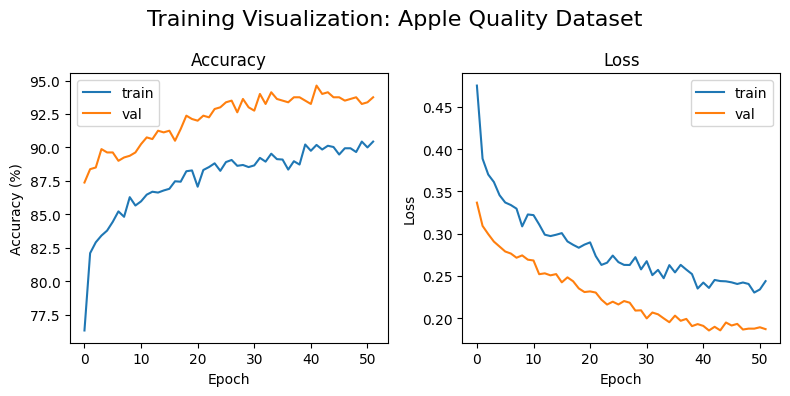

In [12]:
# @title Exercise 1B: Visualize Training

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

# Main title above both subplots
plt.suptitle('Training Visualization: Apple Quality Dataset',
             fontsize=16, fontweight='medium')

plt.subplot(1,2,1)
plt.plot(ap_train_accuracies, label='train')
plt.plot(ap_val_accuracies, label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ap_train_losses, label='train')
plt.plot(ap_val_losses, label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

If the code is correct you should see something _similar_ to the following output:

![__](https://biologicslab.co:/BIO1173/images/class_02/class_02_4_image02A.png)


----------------------------------------
## **Time and Cost of Training Large Language Models (LLMs)**

Large Language Models (LLMs) require a lot of time and money to train. Here is some of the available data as of September 2025.

#### **Largest LLMs (as of September 2025)**

| Model | Approx. size (parameters) | Rough training duration | Rough training cost | Source |
|-------|---------------------------|-------------------------|---------------------|--------|
| **PaLM 2‑G** (Google) | **540 B** | ~4 months on ≈ 5 000–10 000 GPUs (≈ 2 million GPU‑hours) | **$200 M – $250 M** | Google AI blog (2024), “PaLM 2: Language Models for the Web” |
| **GPT‑4** (OpenAI) | **175 B** (largest released variant) | ~3 months on ≈ 10 000–15 000 GPUs (≈ 1.3 million GPU‑hours) | **$30 M – $50 M** | OpenAI press release (2023), estimates from *Bloomberg* and *The Verge* |
| **Claude 3** (Anthropic) | **200 B** | ~3 months on ≈ 8 000 GPUs (≈ 1 million GPU‑hours) | **$30 M – $60 M** | Anthropic blog (2024) |
| **LLaMA‑2‑70B** (Meta) | **70 B** | ~1 month on ≈ 1 500 GPUs (≈ 0.2 million GPU‑hours) | **$5 M – $10 M** | Meta AI research paper (2023) |


####**Quick take-aways**

1. **Largest publicly‑known LLM (as of 2025):**  
   *PaLM 2‑G* – **540 billion** parameters, the only model known to exceed the 175‑B‑parameter range of GPT‑4.

2. **Training time:**  
   Even the smallest “state-of-the-art” models require **weeks to months** on **thousands of GPUs**.  
   * PaLM 2-G ≈ **2 million GPU-hours** → ~4 months on a 5 000‑GPU cluster.

3. **Training cost:**  
   Costs run in the **tens to hundreds of millions** of dollars.  
   * 175B-parameter models: **\$30-50M**  
   * 540B-parameter models: **\$200-250M**

> **Bottom line:**  
> The field is rapidly moving toward ever larger models, but the practical ceiling is still in the *hundreds of billions* of parameters.  Training such a model is a **multi-month, multi‑million‑GPU‑hour operation** that costs **\$30-250 million**, depending on size and hardware budget.

---------------------


### Example 2: Determine the Model's RMSE and Accuracy

The overall objective of this assignment is to convince you that you can save a trained neural network to a file, and then later, recreate the neural network from the file, without changing the model's accuracy.

**Why is this important?**

As you already know, it can take significant time and processing power to train even relatively small neural networks that we created so far in this course. Neural networks that are used commercially (think "Siri" or "Alexa" or ChatGPT) are many times larger and require enormous resources as well as weeks (or months) to train. Obviously, if you had to train a neural network every time you wanted to use it, it won't be very practical and there would be little interest in "AI". However, once the neural network has been trained, you can save it to a file, and then re-use it over and over again, without any loss in the neural network's ability to solve problems (i.e. loss in accuracy).

The code in the cell below calculates the ability of the `or_model` neural network to predict an orange's quality (Y-value) based on its physical and chemical characteristics (X-values). Two measures of predictive ability are computed, the Root Mean Square Error (RMSE) and Accuracy. The code stores the RMSE value in the variable `or_Score` and the Accuracy value in the variable `or_Correct` and then prints out these values.


### Example 2: Determine the Model's RMSE and Accuracy

The code in the cell below calculates 4 **accuracy metrics** about the `or_model` before we save it to disk.

In [13]:
# @title Example 2: Determine the model's accuracy before saving to disk

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Print title
print("Measurements of Orange NN model `or_model`")
print("--------------------------------------------")

# Measure RMSE error (using cross-entropy loss as proxy since we're doing classification)
# For classification, we typically don't use RMSE directly, but here's how you'd calculate it:
with torch.no_grad():
    or_Pred = or_model(or_X_tensor).numpy()  # Get predictions from model
    or_Score = np.sqrt(metrics.mean_squared_error(or_Pred, or_Y))
    print(f"Before save score (RMSE): {or_Score}")

# Measure the accuracy
or_Predict_classes = np.argmax(or_Pred,axis=1)
or_Expected_classes = np.argmax(or_Y,axis=1)
or_Correct = accuracy_score(or_Expected_classes,or_Predict_classes)
print(f"Before save Accuracy: {or_Correct}")

Measurements of Orange NN model `or_model`
--------------------------------------------
Before save score (RMSE): 0.5760088673842864
Before save Accuracy: 0.5518672199170125


If the code is correct you should see something _similar_ to the following output:
```text
Measurements of Orange NN model `or_model`
--------------------------------------------
Before save score (RMSE): 0.5760088673842864
Before save Accuracy: 0.5518672199170125
```

We are going to use these scores to see if the model we save and then redeploy has the same accuracy or does the model's accuracy suffer?

### **Exercise 2: Determine the Model's Accuracy**

In the cell below, write the code to calculate the same **accuracy metrics** for your `ap_model` shown in `Example 2` before we save it to disk.

In [14]:
# @title Exercise 2: Determine the Model's Accuracy

import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Print title
print("Measurements of Apple NN model `ap_model`")
print("--------------------------------------------")

# Measure RMSE error (using cross-entropy loss as proxy since we're doing classification)
# For classification, we typically don't use RMSE directly, but here's how you'd calculate it:
with torch.no_grad():
    ap_Pred = ap_model(ap_X_tensor).numpy()  # Get predictions from model
    ap_Score = np.sqrt(metrics.mean_squared_error(ap_Pred, ap_Y))
    print(f"Before save score (RMSE): {ap_Score}")

# Measure the accuracy
ap_Predict_classes = np.argmax(ap_Pred,axis=1)
ap_Expected_classes = np.argmax(ap_Y,axis=1)
ap_Correct = accuracy_score(ap_Expected_classes,ap_Predict_classes)
print(f"Before save Accuracy: {ap_Correct}")

Measurements of Apple NN model `ap_model`
--------------------------------------------
Before save score (RMSE): 2.110792009039741
Before save Accuracy: 0.94675


If your code is correct you should see something _similar_ to the following output:
```text
Measurements of Apple NN model `ap_model`
--------------------------------------------
Before save score (RMSE): 2.110792009039741
Before save Accuracy: 0.94675
```
According to the output shown above, your `ap_model` is better than 95% accurate when it comes to predicting apple quality. Apparently, it's a little easier to predict an apple's `Quality` with a classification neural network than to predict orange quality.

In **PyTorch**, the primary difference lies in what is stored and how you must load it.
### **PyTorch state_dict**
* **What it is:** A standard Python dictionary that maps each layer name to its specific parameter tensors (weights and biases) and buffers (like BatchNorm running means).
* **Storage:** It stores only the parameters, not the model's architecture or source code.
* **Loading:** To use it, you must first initialize the model in your code (e.g., model = MyModel()) and then call model.load_state_dict(torch.load(PATH)).
Best For: Production and sharing models. It is the recommended approach because it is flexible and doesn't break if you move your files around or refactor your project.

### **Full Model (torch.save(model, PATH))**
* **What it is:** A serialized version of the entire model object using Python’s pickle module.
* **Storage:** It saves the architecture, parameters, and the file path to the class definition.
* **Loading:** You can load it directly with model = torch.load(PATH) without defining the class first in your script.

### Example 3: Save the Model

The code in the cell below saves the trained neural network `or_model` as a file in two different file formats: **`PyTorch state dict`** and **`full model`**.

Each file is saved in the current working directory (save_path = "."). The filename of the state dict file is `or_model_pytorch.pth` while the filename of the full model file is `or_full_model_pytorch.pth`.

In [15]:
# @title Example 3: Save the model

import os
import torch

# Save path is the current directory
save_path = "."

# Save the PyTorch model state dict (weights and architecture)
torch.save(or_model.state_dict(), os.path.join(save_path, "or_model_pytorch.pth"))

# Save the entire model (architecture + weights)
torch.save(or_model, os.path.join(save_path, "or_full_model_pytorch.pth"))

# Print out the files in current directory
files = os.listdir()
print(files)


['.config', 'drive', 'or_full_model_pytorch.pth', 'or_best_classification_model.pth', 'or_model_pytorch.pth', 'ap_best_classification_model.pth', 'sample_data']


If your code is correct you should see something _similar_ to the following output:

```text
['.config', 'or_full_model_pytorch.pth', 'ap_best_classification_model.pth', 'or_model_pytorch.pth', 'drive', 'or_best_classification_model.pth', 'sample_data']
```
After running the code cell above, there should now be two new files in your current directory, `or_model_pytorch.pth` and `or_full_model_pytorch.pth`.

### **Exercise 3: Save the Model**

In the code cell below save your _trained_ neural network `ap_model` as a JSON file with the filename, `ap_model.json`, and as a native Keras file with the filenmane `ap_model.keras`. Save both files to your current working directory (`save_path = "."`).

In [16]:
# @title Exercise 3: Save the Model

import os
import torch

# Save path is the current directory
save_path = "."

# Save the PyTorch model state dict (weights and architecture)
torch.save(ap_model.state_dict(), os.path.join(save_path, "ap_model_pytorch.pth"))

# Save the entire model (architecture + weights)
torch.save(ap_model, os.path.join(save_path, "ap_full_model_pytorch.pth"))

# Print out the files in current directory
files = os.listdir()
print(files)


['.config', 'drive', 'or_full_model_pytorch.pth', 'or_best_classification_model.pth', 'or_model_pytorch.pth', 'ap_model_pytorch.pth', 'ap_full_model_pytorch.pth', 'ap_best_classification_model.pth', 'sample_data']


You should now see the two more files with your neural network, `ap_model_pytorch.pth` and `ap_full_model_pytorch.pth`.

### Example 4: Create New Model from Saved Model

Once a trained model has been saved, it is a simple matter to read the file to make an exact copy of the model. In PyTorch, we need to recreate the model architecture first and then load the saved weights into it.

In Example 4, we have recreated the neural network architecture and loaded the saved weights into a new model instance called `or2_model` to differentiate it from the one that was built previously.

In [17]:
# @title Example 4: Create new model from saved model

import torch
from torch import nn
import os

print("=== Model Loading Verification ===")

# Print details of model
print(f"Training data shapes:")
print(f"X shape: {or_X.shape}")  # Should be (samples, 8)
print(f"Y shape: {or_Y.shape}")  # This is 8

# Check dimensions
num_classes = or_Y.shape[1]  # This is 8 - so we need to create a model with 8 output classes
input_dim = or_X.shape[1]   # This is 8 - 8 input features

print(f"Input features: {input_dim}")
print(f"Number of classes: {num_classes}")

# Recreate the EXACT same model class structure as used in training
class OrangeQualityModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OrangeQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create model with EXACT same dimensions as training
or2_model = OrangeQualityModel(input_dim, num_classes)  # input_dim=8, num_classes=8

try:
    print("Loading weights from saved model...")
    or2_model.load_state_dict(torch.load("or_model_pytorch.pth"))
    print("✓ Orange Quality model loaded successfully!")

except Exception as e:
    print(f"✗ Error loading model: {e}")

=== Model Loading Verification ===
Training data shapes:
X shape: (241, 8)
Y shape: (241, 8)
Input features: 8
Number of classes: 8
Loading weights from saved model...
✓ Orange Quality model loaded successfully!


If your code is correct you should see the following output:
```text
=== Model Loading Verification ===
Training data shapes:
X shape: (241, 8)
Y shape: (241, 8)
Input features: 8
Number of classes: 8
Loading weights from saved model...
✓ Orange Quality model loaded successfully!
```

### **Exercise 4: Create New Model from Saved Model**

In the cell below create a new neural network called `ap2_model` from the file `ap_model_pytorch.pth` in your current directory. Print out a summary of your new `ap2_model`.

**Code Hints:**

Change the class name `OrangeQualityModel` to read `AppleQualityModel`.

In [18]:
# @title Exercise 4: Create New Model from Saved Model

import torch
from torch import nn
import os

print("=== Model Loading Verification ===")

# Print details of model
print(f"Training data shapes:")
print(f"X shape: {ap_X.shape}")
print(f"Y shape: {ap_Y.shape}")

# Check dimensions
num_classes = ap_Y.shape[1]
input_dim = ap_X.shape[1]

print(f"Input features: {input_dim}")
print(f"Number of classes: {num_classes}")

# Recreate the EXACT same model class structure as used in training
class AppleQualityModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(AppleQualityModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create model with EXACT same dimensions as training
ap2_model = AppleQualityModel(input_dim, num_classes)
try:
    print("Loading weights from saved model...")
    ap2_model.load_state_dict(torch.load("ap_model_pytorch.pth"))
    print("✓ Apple Quality model loaded successfully!")

except Exception as e:
    print(f"✗ Error loading model: {e}")

=== Model Loading Verification ===
Training data shapes:
X shape: (4000, 7)
Y shape: (4000, 2)
Input features: 7
Number of classes: 2
Loading weights from saved model...
✓ Apple Quality model loaded successfully!


If your code is correct you should see the following output:

```text
=== Model Loading Verification ===
Training data shapes:
X shape: (4000, 7)
Y shape: (4000, 2)
Input features: 7
Number of classes: 2
Loading weights from saved model...
✓ Apple Quality model loaded successfully!
```

### Example 5: Compare the Predictive Accuracy of the Old and New Models

The code in the cell below computes the RMSE error and the Accuracy of our new model `or2_model` and compares these values with the original `or_model`. We are trying to address the question whether re-loaded model has the same accuracy as the original model?

In [19]:
# Example 5: Compare the Predictive Accuracy of the Old and New Models

# Set both models to evaluation mode for consistent predictions
or_model.eval()  # Make sure original is in eval mode
or2_model.eval()  # Make sure new model is also in eval mode

print("\n=== MODEL VERIFICATION ===")
with torch.no_grad():
    # Get predictions from both models (both should be in eval mode now)
    or_pred = or_model(or_X_tensor).numpy()
    or2_pred = or2_model(or_X_tensor).numpy()

    print(f"Original model prediction shape: {or_pred.shape}")
    print(f"New model prediction shape: {or2_pred.shape}")

    # Show first few predictions for comparison
    orig_preds = np.argmax(or_pred, axis=1)
    new_preds = np.argmax(or2_pred, axis=1)

    print(f"\nOriginal model (first 5): {orig_preds[:5]}")
    print(f"New model      (first 5): {new_preds[:5]}")

    # Check exact match
    are_equal = np.array_equal(orig_preds, new_preds)
    print(f"\nPredictions identical: {are_equal}")

    if not are_equal:
        diff_count = np.sum(orig_preds != new_preds)
        print(f"Number of different predictions: {diff_count}")

        # Show some examples where they differ
        diff_indices = np.where(orig_preds != new_preds)[0]
        if len(diff_indices) > 0:
            print("First few differing indices:", diff_indices[:5])
            for i in range(min(5, len(diff_indices))):
                idx = diff_indices[i]
                print(f"Index {idx}: Original={orig_preds[idx]}, New={new_preds[idx]}")

print("\n=== Model Architecture Check ===")
print("Original model:")
print(or_model)
print("\nNew loaded model:")
print(or2_model)

# Let's also check the weights are identical
print("\n=== Weight Comparison ===")
weight_diffs = []
for (name1, param1), (name2, param2) in zip(or_model.named_parameters(), or2_model.named_parameters()):
    diff = torch.sum(torch.abs(param1 - param2)).item()
    weight_diffs.append(diff)
    print(f"{name1}: difference = {diff:.2e}")

total_weight_diff = sum(weight_diffs)
print(f"\nTotal weight difference: {total_weight_diff:.2e}")



=== MODEL VERIFICATION ===
Original model prediction shape: (241, 8)
New model prediction shape: (241, 8)

Original model (first 5): [7 6 7 3 6]
New model      (first 5): [7 6 7 3 6]

Predictions identical: True

=== Model Architecture Check ===
Original model:
OrangeQualityModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

New loaded model:
OrangeQualityModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, ou

If the code is correct the output you should see something _similar_ to the following output:`

```text
=== MODEL VERIFICATION ===
Original model prediction shape: (241, 8)
New model prediction shape: (241, 8)

Original model (first 5): [7 6 7 3 6]
New model      (first 5): [7 6 7 3 6]

Predictions identical: True

=== Model Architecture Check ===
Original model:
OrangeQualityModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

New loaded model:
OrangeQualityModel(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
)

=== Weight Comparison ===
fc1.weight: difference = 0.00e+00
fc1.bias: difference = 0.00e+00
bn1.weight: difference = 0.00e+00
bn1.bias: difference = 0.00e+00
fc2.weight: difference = 0.00e+00
fc2.bias: difference = 0.00e+00
bn2.weight: difference = 0.00e+00
bn2.bias: difference = 0.00e+00
fc3.weight: difference = 0.00e+00
fc3.bias: difference = 0.00e+00

Total weight difference: 0.00e+00
```

As you can see, there is **_no difference_** in the accuracy of the saved model compared to the original one.

>> ### **_Train Once_...Use Anywhere!**

Big generative models like `ChatGTP` can take days or even months to train, but once they are trained and saved, they can process new data very fast at very little cost.

### **Exercise 5: Compare the Predictive Accuracy of the Old and New Models**

In the cell below write the code to compute the RMSE and Accuracy values for your `ap2Model` and print out these values along with the values for your original `ap_model`.

In [20]:
# @title Exercise 5: Compare the Predictive Accuracy of the Old and New Models

# Set both models to evaluation mode for consistent predictions
ap_model.eval()  # Make sure original is in eval mode
ap2_model.eval()  # Make sure new model is also in eval mode

print("\n=== MODEL VERIFICATION ===")
with torch.no_grad():
    # Get predictions from both models (both should be in eval mode now)
    ap_pred = ap_model(ap_X_tensor).numpy()
    ap2_pred = ap2_model(ap_X_tensor).numpy()

    print(f"Original model prediction shape: {ap_pred.shape}")
    print(f"New model prediction shape: {ap2_pred.shape}")

    # Show first few predictions for comparison
    orig_preds = np.argmax(ap_pred, axis=1)
    new_preds = np.argmax(ap2_pred, axis=1)

    print(f"\nOriginal model (first 5): {orig_preds[:5]}")
    print(f"New model      (first 5): {new_preds[:5]}")

    # Check exact match
    are_equal = np.array_equal(orig_preds, new_preds)
    print(f"\nPredictions identical: {are_equal}")

    if not are_equal:
        diff_count = np.sum(orig_preds != new_preds)
        print(f"Number of different predictions: {diff_count}")

        # Show some examples where they differ
        diff_indices = np.where(orig_preds != new_preds)[0]
        if len(diff_indices) > 0:
            print("First few differing indices:", diff_indices[:5])
            for i in range(min(5, len(diff_indices))):
                idx = diff_indices[i]
                print(f"Index {idx}: Original={orig_preds[idx]}, New={new_preds[idx]}")

print("\n=== Model Architecture Check ===")
print("Original model:")
print(ap_model)
print("\nNew loaded model:")
print(ap2_model)

# Let's also check the weights are identical
print("\n=== Weight Comparison ===")
weight_diffs = []
for (name1, param1), (name2, param2) in zip(ap_model.named_parameters(), ap2_model.named_parameters()):
    diff = torch.sum(torch.abs(param1 - param2)).item()
    weight_diffs.append(diff)
    print(f"{name1}: difference = {diff:.2e}")

total_weight_diff = sum(weight_diffs)
print(f"\nTotal weight difference: {total_weight_diff:.2e}")



=== MODEL VERIFICATION ===
Original model prediction shape: (4000, 2)
New model prediction shape: (4000, 2)

Original model (first 5): [1 1 0 1 1]
New model      (first 5): [1 1 0 1 1]

Predictions identical: True

=== Model Architecture Check ===
Original model:
AppleQualityModel(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

New loaded model:
AppleQualityModel(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, ou

If the code is correct, you should see something _similar_ to the following output:
```text
=== MODEL VERIFICATION ===
Original model prediction shape: (4000, 2)
New model prediction shape: (4000, 2)

Original model (first 5): [1 1 0 1 1]
New model      (first 5): [1 1 0 1 1]

Predictions identical: True

=== Model Architecture Check ===
Original model:
AppleQualityModel(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

New loaded model:
AppleQualityModel(
  (fc1): Linear(in_features=7, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

=== Weight Comparison ===
fc1.weight: difference = 0.00e+00
fc1.bias: difference = 0.00e+00
bn1.weight: difference = 0.00e+00
bn1.bias: difference = 0.00e+00
fc2.weight: difference = 0.00e+00
fc2.bias: difference = 0.00e+00
bn2.weight: difference = 0.00e+00
bn2.bias: difference = 0.00e+00
fc3.weight: difference = 0.00e+00
fc3.bias: difference = 0.00e+00

Total weight difference: 0.00e+00
```

## **Summary: Pre-trained Model Persistence and Its Importance for Large Language Models**

The ability to save and reload trained PyTorch neural networks without any loss of accuracy represents a fundamental breakthrough in machine learning workflow efficiency. When we train a complex neural network, especially one with millions or billions of parameters like modern large language models (LLMs), the training process can take weeks or months using powerful computational resources. However, once training is complete, we can save the model's weights and architecture to disk, creating a portable file that captures all the learned knowledge.

This capability becomes critically important in the era of extremely large LLMs because these models require enormous computational resources for training - often costing thousands of dollars in cloud computing time and consuming massive amounts of energy. By saving trained models, practitioners can:
1. Avoid retraining identical or similar architectures from scratch
2. Deploy models to production environments immediately
3. Share pre-trained models with others in the research community
4. Fine-tune existing models on new datasets without starting from random weights

For LLMs specifically, this persistence allows researchers and developers to build upon existing knowledge rather than reinventing the wheel each time. A model trained on general text can be saved, then fine-tuned for specific applications like medical diagnosis, legal document analysis, or creative writing - all while maintaining the original model's accuracy and performance characteristics. This approach democratizes access to sophisticated AI capabilities by making powerful pre-trained models accessible to organizations that cannot afford expensive training infrastructure, ultimately accelerating innovation in artificial intelligence.


## **Electronic Submission**

When you run the code in the cell below, it will grade your Colab notebook and tell you your pending grade as it currently stands. You will be given the choice to either submit your notebook for final grading or the option to continue your work on one (or more) Exercises. You no longer have the option to upload a PDF of your Colab notebook to Canvas for grading. Grant Access to your Colab Secrets if you are asked to do so.

**NOTE:** You grade on this Colab notebook will be based solely on the code in your **Exercises**. Failure to run one (or more) Examples will not affect your grade.

In [21]:
# @title  Electronic Submission

import urllib.request
import ssl
import time

url = "https://biologicslab.co/BIO1173/backend_code/validate.py?v=" + str(time.time())

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

req = urllib.request.Request(
    url,
    headers={
        "Cache-Control": "no-cache, no-store, must-revalidate",
        "Pragma": "no-cache",
        "Expires": "0"
    }
)

with urllib.request.urlopen(req, context=ctx) as r:
    exec(r.read().decode("utf-8"))

main()

Credentials Check
UTSA ID  ✅
Gmail    ✅
API Key  ✅
Notebook: CLASS_02_4
Notebook collected ✅  (233,444 bytes)

Grading notebook — this may take a moment…
✅  Preliminary grading complete  (ID: BIO1173_699e603ac1f91)
❌  Could not grade notebook: Solution notebook not found: /home/george/BIO1173/AnswerKeys/Class_02_4_Solutions.ipynb


Output()